In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [2]:
tf.random.set_seed(69)
random.seed(69)
np.random.seed(69)
os.environ["PYTHONHASHSEED"] = str(69)

In [91]:
df = pd.read_csv('./data/dailySentiment.csv')
df.head()

,Unnamed: 0,Day,Price,Sentiment
0,0,20150105,3.22,-0.534077
1,1,20150106,2.98,-0.337025
2,2,20150107,3.08,-0.065357
3,3,20150108,2.92,-0.326590
4,4,20150109,2.96,-0.374404


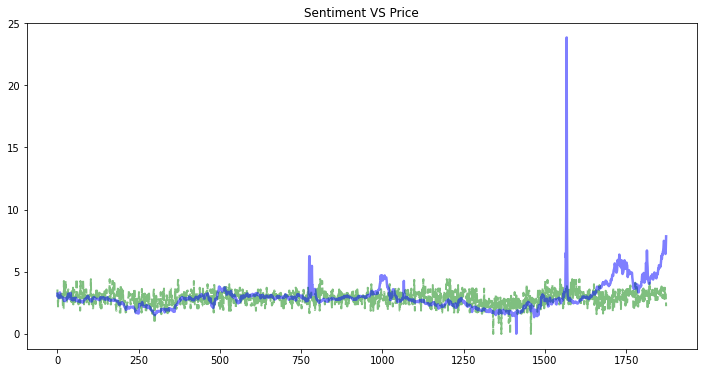

In [92]:
avg = sum(list(df.Price))/len(list(df.Price))
sen = list(df.Sentiment)
price = list(df.Price)
for i in range (len(sen)):
    sen[i] = -(sen[i]*avg)+2
plt.figure(figsize=(12, 6))
l1 = plt.plot(sen, lw = 2, color='green', alpha=0.5, linestyle='dashed')
l2 = plt.plot(price, lw = 2.5, color='blue', alpha=0.5)
plt.title('Sentiment VS Price')
plt.show()

In [93]:
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j], df.Sentiment[i+j]])
        res.append([0, df.Sentiment[i+window]])
        xRes.append(res)
        yRes.append(df.Price[i+window])
    tf.convert_to_tensor(xRes)
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [94]:
SPLIT = 0.85
xVal, yVal = singleStepSampler(df, 20)
xTrain = xVal[:int(SPLIT*len(xVal))]
yTrain = yVal[:int(SPLIT*len(yVal))]
xTest = xVal[int(SPLIT*len(xVal)):]
yTest = yVal[int(SPLIT*len(yVal)):]
(xTrain.shape, xTest.shape)

(TensorShape([1541, 61, 2]), TensorShape([273, 61, 2]))

In [95]:
(xTrain[0], yTrain[0])

(<tf.Tensor: shape=(61, 2), dtype=float64, numpy=
 array([[ 3.22      , -0.53407659],
        [ 2.98      , -0.33702523],
        [ 3.08      , -0.06535698],
        [ 2.92      , -0.32659015],
        [ 2.96      , -0.37440371],
        [ 2.9       , -0.28797958],
        [ 2.92      , -0.32659015],
        [ 3.15      , -0.3090599 ],
        [ 3.32      , -0.28900051],
        [ 3.11      , -0.38719366],
        [ 2.94      , -0.35766462],
        [ 2.94      , -0.35766462],
        [ 2.95      , -0.44056478],
        [ 2.96      , -0.37440371],
        [ 2.92      , -0.32659015],
        [ 2.96      , -0.37440371],
        [ 2.89      , -0.39860696],
        [ 2.88      , -0.01438307],
        [ 2.88      , -0.01438307],
        [ 2.88      , -0.01438307],
        [ 2.67      , -0.76904183],
        [ 2.73      , -0.36304305],
        [ 2.66      , -0.55783274],
        [ 2.66      , -0.55783274],
        [ 2.62      , -0.47305674],
        [ 2.67      , -0.76904183],
        [ 2.86

In [96]:
def smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - y_true) / summ * 2.0
    return smape

In [97]:
hybridModel = tf.keras.Sequential()
hybridModel.add(tf.keras.layers.Conv1D(32, kernel_size=(3), input_shape=(21, 2)))
hybridModel.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
hybridModel.add(tf.keras.layers.LSTM(256, return_sequences=True))
hybridModel.add(tf.keras.layers.Flatten())
hybridModel.add(tf.keras.layers.Dense(128, activation='relu'))
hybridModel.add(tf.keras.layers.Dense(1, activation='linear'))
hybridModel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', smape])

In [98]:
hybridModel.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
49/49 [==============================] - 6s 21ms/step - loss: 0.4563 - mse: 0.9729 - mae: 0.4563 - smape: 0.1738
Epoch 2/50
49/49 [==============================] - 1s 25ms/step - loss: 0.2481 - mse: 0.4483 - mae: 0.2481 - smape: 0.0863
Epoch 3/50
49/49 [==============================] - 2s 34ms/step - loss: 0.2389 - mse: 0.4236 - mae: 0.2389 - smape: 0.0831
Epoch 4/50
49/49 [==============================] - 1s 28ms/step - loss: 0.2211 - mse: 0.3924 - mae: 0.2211 - smape: 0.0765
Epoch 5/50
49/49 [==============================] - 1s 22ms/step - loss: 0.1815 - mse: 0.3583 - mae: 0.1815 - smape: 0.0620
Epoch 6/50
49/49 [==============================] - 1s 22ms/step - loss: 0.1712 - mse: 0.3455 - mae: 0.1712 - smape: 0.0587
Epoch 7/50
49/49 [==============================] - 1s 21ms/step - loss: 0.1577 - mse: 0.3140 - mae: 0.1577 - smape: 0.0538
Epoch 8/50
49/49 [==============================] - 1s 18ms/step - loss: 0.1564 - mse: 0.2957 - mae: 0.1564 - smape: 0.0535
Epoch 9/

In [15]:
hybridModel.save('./models/singleStepDailyHybrid.h5')

In [11]:
hybridModel = tf.keras.models.load_model('./models/singleStepDailyHybrid.h5', custom_objects={'smape': smape})

In [35]:
LSTMModel = tf.keras.Sequential()
LSTMModel.add(tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(21, 2)))
# LSTMModel.add(tf.keras.layers.LSTM(128, activation='relu'))
LSTMModel.add(tf.keras.layers.Flatten())
LSTMModel.add(tf.keras.layers.Dense(128, activation='relu'))
LSTMModel.add(tf.keras.layers.Dense(1, activation='linear'))
LSTMModel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae', smape])

In [36]:
LSTMModel.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
50/50 [==============================] - 8s 17ms/step - loss: 0.2809 - mse: 0.5682 - mae: 0.2809 - smape: 0.1113
Epoch 2/50
50/50 [==============================] - 1s 14ms/step - loss: 0.1856 - mse: 0.3644 - mae: 0.1856 - smape: 0.0624
Epoch 3/50
50/50 [==============================] - 1s 15ms/step - loss: 0.1733 - mse: 0.3462 - mae: 0.1733 - smape: 0.0579
Epoch 4/50
50/50 [==============================] - 1s 15ms/step - loss: 0.2085 - mse: 0.3495 - mae: 0.2085 - smape: 0.0711
Epoch 5/50
50/50 [==============================] - 1s 16ms/step - loss: 0.1576 - mse: 0.3051 - mae: 0.1576 - smape: 0.0530
Epoch 6/50
50/50 [==============================] - 1s 18ms/step - loss: 0.1541 - mse: 0.3068 - mae: 0.1541 - smape: 0.0517
Epoch 7/50
50/50 [==============================] - 1s 21ms/step - loss: 0.1360 - mse: 0.2754 - mae: 0.1360 - smape: 0.0456
Epoch 8/50
50/50 [==============================] - 1s 20ms/step - loss: 0.1506 - mse: 0.2732 - mae: 0.1506 - smape: 0.0510
Epoch 9/

In [38]:
LSTMModel.save('./models/singleStepDailyLSTM.h5')

In [14]:
LSTMModel = tf.keras.models.load_model('./models/singleStepDailyLSTM.h5', custom_objects={'smape': smape})

In [31]:
CNNModel = tf.keras.Sequential()
CNNModel.add(tf.keras.layers.Conv1D(32, kernel_size=(2), input_shape=(21, 2)))
CNNModel.add(tf.keras.layers.Flatten())
CNNModel.add(tf.keras.layers.Dense(128, activation='relu'))
CNNModel.add(tf.keras.layers.Dense(1, activation='linear'))
CNNModel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,), metrics=['mse', 'mae', smape])

In [32]:
CNNModel.fit(xTrain, yTrain, epochs=50)

Epoch 1/50
50/50 [==============================] - 1s 9ms/step - loss: 0.3541 - mse: 0.6041 - mae: 0.3541 - smape: 0.1279
Epoch 2/50
50/50 [==============================] - 0s 9ms/step - loss: 0.1774 - mse: 0.3383 - mae: 0.1774 - smape: 0.0598
Epoch 3/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1919 - mse: 0.3279 - mae: 0.1919 - smape: 0.0649
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1721 - mse: 0.3034 - mae: 0.1721 - smape: 0.0583
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1837 - mse: 0.2898 - mae: 0.1837 - smape: 0.0633
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 0.1810 - mse: 0.2954 - mae: 0.1810 - smape: 0.0622
Epoch 7/50
50/50 [==============================] - 0s 9ms/step - loss: 0.1328 - mse: 0.2642 - mae: 0.1328 - smape: 0.0447
Epoch 8/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1437 - mse: 0.2591 - mae: 0.1437 - smape: 0.0483
Epoch 9/50
50/50

In [34]:
CNNModel.save('./models/singleStepDailyCNN.h5')

In [13]:
CNNModel = tf.keras.models.load_model('./models/singleStepDailyCNN.h5', custom_objects={'smape': smape})

In [37]:
print(hybridModel.evaluate(xTest, yTest))
print(LSTMModel.evaluate(xTest, yTest))
print(CNNModel.evaluate(xTest, yTest))

9/9 [==============================] - 0s 18ms/step - loss: 0.1520 - mse: 0.0572 - mae: 0.1520 - smape: 0.0322
[0.1520003378391266, 0.057202719151973724, 0.1520003378391266, 0.0322149358689785]
9/9 [==============================] - 1s 6ms/step - loss: 0.1641 - mse: 0.0624 - mae: 0.1641 - smape: 0.0352
[0.16411904990673065, 0.06243811175227165, 0.16411904990673065, 0.03524209186434746]
9/9 [==============================] - 0s 6ms/step - loss: 0.1581 - mse: 0.0553 - mae: 0.1581 - smape: 0.0337
[0.15812936425209045, 0.05534428730607033, 0.15812936425209045, 0.03366849943995476]


In [51]:
hybrid, lstm, cnn = [], [], []
for item in xTest:
    print(np.array([item]))
    hybrid.append(hybridModel.predict(np.array([item])))
    lstm.append(LSTMModel.predict(np.array([item])))
    cnn.append(CNNModel.predict(np.array([item])))

[[[ 2.7        -0.4448338 ]
  [ 2.87       -0.17962492]
  [ 2.86       -0.52417843]
  [ 2.79       -0.32171516]
  [ 2.72       -0.124277  ]
  [ 2.67       -0.76904183]
  [ 2.62       -0.47305674]
  [ 2.62       -0.47305674]
  [ 2.7        -0.4448338 ]
  [ 2.65       -0.8192868 ]
  [ 2.58       -0.32072873]
  [ 2.5        -0.29020108]
  [ 2.6        -0.37207218]
  [ 2.45       -0.66663613]
  [ 2.53       -0.46290142]
  [ 2.55       -0.79966372]
  [ 2.56       -0.54804678]
  [ 2.56       -0.54804678]
  [ 2.52       -0.49545295]
  [ 2.52       -0.49545295]
  [ 0.         -0.32072873]]]
[[[ 2.87       -0.17962492]
  [ 2.86       -0.52417843]
  [ 2.79       -0.32171516]
  [ 2.72       -0.124277  ]
  [ 2.67       -0.76904183]
  [ 2.62       -0.47305674]
  [ 2.62       -0.47305674]
  [ 2.7        -0.4448338 ]
  [ 2.65       -0.8192868 ]
  [ 2.58       -0.32072873]
  [ 2.5        -0.29020108]
  [ 2.6        -0.37207218]
  [ 2.45       -0.66663613]
  [ 2.53       -0.46290142]
  [ 2.55       -0.

In [50]:
(hybrid, cnn, lstm)

([], [], [])

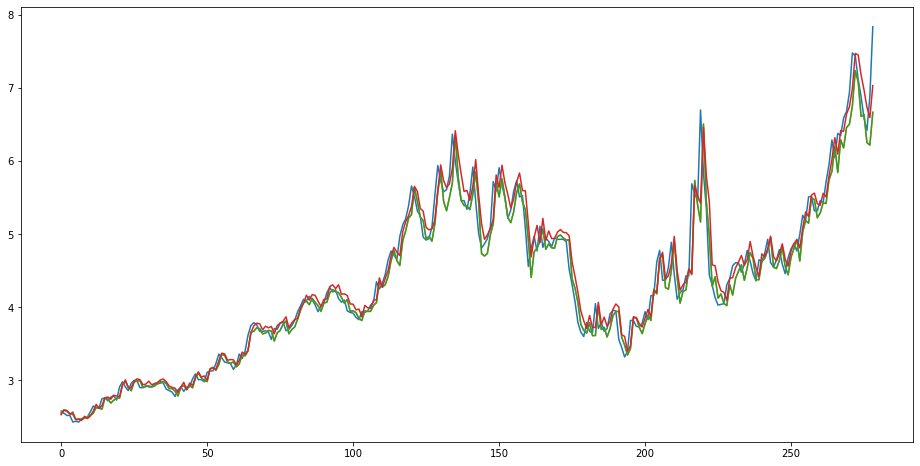

In [55]:
dafr = pd.DataFrame(data={'actual': yTest, 'hybrid': [item[0][0] for item in hybrid], 'lstm': [item[0][0] for item in hybrid], 'cnn': [item[0][0] for item in cnn]})
plt.figure(figsize=(16, 8))
plt.plot(dafr)
plt.show()

In [72]:
def multiStepSampler(df, window, door):
    xRes = []
    yRes = []
    for i in range(0, len(df)-window-door):
        res = []
        for j in range(0, window):
            res.append([df.Price[i+j]])
        xRes.append(res)
        yRes.append(df.Price[window:window+door])
    return (tf.convert_to_tensor(xRes), tf.convert_to_tensor(yRes))

In [99]:
df = pd.read_csv('./data/daily.csv')
df.head()

,Day,Price
0,19970107,3.82
1,19970108,3.80
2,19970109,3.61
3,19970110,3.92
4,19970113,4.00


In [100]:
SPLIT = 0.85
xVal, yVal = multiStepSampler(df, 60, 30)
xTrain = xVal[:int(SPLIT*len(xVal))]
yTrain = yVal[:int(SPLIT*len(yVal))]
xTest = xVal[int(SPLIT*len(xVal)):]
yTest = yVal[int(SPLIT*len(yVal)):]
(xTrain.shape, yTrain.shape)

(TensorShape([5350, 60, 1]), TensorShape([5350, 30]))

In [130]:
xTrain[0]

<tf.Tensor: shape=(60, 1), dtype=float64, numpy=
array([[3.82],
       [3.8 ],
       [3.61],
       [3.92],
       [4.  ],
       [4.01],
       [4.34],
       [4.71],
       [3.91],
       [3.26],
       [2.99],
       [3.05],
       [2.96],
       [2.62],
       [2.98],
       [3.05],
       [2.91],
       [2.86],
       [2.77],
       [2.49],
       [2.59],
       [2.65],
       [2.51],
       [2.39],
       [2.42],
       [2.34],
       [2.42],
       [2.22],
       [2.12],
       [1.84],
       [1.95],
       [1.92],
       [1.92],
       [1.92],
       [1.77],
       [1.81],
       [1.8 ],
       [1.78],
       [1.8 ],
       [1.87],
       [1.92],
       [1.82],
       [1.89],
       [1.95],
       [1.92],
       [1.96],
       [1.98],
       [1.97],
       [2.01],
       [1.91],
       [1.88],
       [1.88],
       [1.87],
       [1.8 ],
       [1.85],
       [1.85],
       [1.84],
       [1.84],
       [1.95],
       [1.85]])>

In [131]:
yTrain[0]

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([1.87, 1.91, 1.99, 2.01, 1.96, 1.97, 1.98, 2.  , 2.  , 2.02, 2.08,
       2.1 , 2.09, 2.1 , 2.22, 2.11, 2.16, 2.1 , 2.09, 2.16, 2.19, 2.21,
       2.23, 2.25, 2.34, 2.33, 2.3 , 2.27, 2.18, 2.22], dtype=float32)>

In [133]:
xTrain[5]

<tf.Tensor: shape=(60, 1), dtype=float64, numpy=
array([[4.01],
       [4.34],
       [4.71],
       [3.91],
       [3.26],
       [2.99],
       [3.05],
       [2.96],
       [2.62],
       [2.98],
       [3.05],
       [2.91],
       [2.86],
       [2.77],
       [2.49],
       [2.59],
       [2.65],
       [2.51],
       [2.39],
       [2.42],
       [2.34],
       [2.42],
       [2.22],
       [2.12],
       [1.84],
       [1.95],
       [1.92],
       [1.92],
       [1.92],
       [1.77],
       [1.81],
       [1.8 ],
       [1.78],
       [1.8 ],
       [1.87],
       [1.92],
       [1.82],
       [1.89],
       [1.95],
       [1.92],
       [1.96],
       [1.98],
       [1.97],
       [2.01],
       [1.91],
       [1.88],
       [1.88],
       [1.87],
       [1.8 ],
       [1.85],
       [1.85],
       [1.84],
       [1.84],
       [1.95],
       [1.85],
       [1.87],
       [1.91],
       [1.99],
       [2.01],
       [1.96]])>

In [109]:
hybridModel = tf.keras.Sequential()
hybridModel.add(tf.keras.layers.Conv1D(32, kernel_size=(3), input_shape=(60, 1)))
hybridModel.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
hybridModel.add(tf.keras.layers.LSTM(256, return_sequences=True))
hybridModel.add(tf.keras.layers.Flatten())
hybridModel.add(tf.keras.layers.Dense(128, activation='relu'))
hybridModel.add(tf.keras.layers.Dense(30, activation='linear'))
hybridModel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', smape])

In [111]:
hybridModel.fit(xTrain, yTrain, epochs=30)

Epoch 1/30
168/168 [==============================] - 6s 18ms/step - loss: 0.1344 - mse: 0.1366 - mae: 0.1344 - smape: 0.0714
Epoch 2/30
168/168 [==============================] - 3s 20ms/step - loss: 0.0372 - mse: 0.0022 - mae: 0.0372 - smape: 0.0172
Epoch 3/30
168/168 [==============================] - 3s 17ms/step - loss: 0.0287 - mse: 0.0013 - mae: 0.0287 - smape: 0.0133
Epoch 4/30
168/168 [==============================] - 3s 17ms/step - loss: 0.0276 - mse: 0.0012 - mae: 0.0276 - smape: 0.0128
Epoch 5/30
168/168 [==============================] - 3s 17ms/step - loss: 0.0250 - mse: 0.0010 - mae: 0.0250 - smape: 0.0116
Epoch 6/30
168/168 [==============================] - 2s 11ms/step - loss: 0.0226 - mse: 8.1637e-04 - mae: 0.0226 - smape: 0.0105
Epoch 7/30
168/168 [==============================] - 3s 19ms/step - loss: 0.0233 - mse: 8.7559e-04 - mae: 0.0233 - smape: 0.0107
Epoch 8/30
168/168 [==============================] - 2s 12ms/step - loss: 0.0202 - mse: 6.4616e-04 - mae: 0.0

In [112]:
hybridModel.evaluate(xTest, yTest)

30/30 [==============================] - 0s 10ms/step - loss: 0.0101 - mse: 1.7112e-04 - mae: 0.0101 - smape: 0.0046


[0.010100782848894596,
 0.0001711204240564257,
 0.010100782848894596,
 0.0046449205838143826]

<AxesSubplot:>

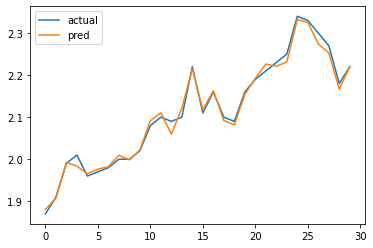

In [129]:
pred = np.array(hybridModel.predict(np.array([xTest[0]]))).tolist()
dafr = pd.DataFrame(data={'actual': np.array(yTest[0]).tolist(), 'pred': pred[0]})
dafr.plot()